In [3]:
import os
from scipy.io import wavfile
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, Flatten, LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from keras.regularizers import l1_l2
from sklearn.utils.class_weight import compute_class_weight as sklearn_compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from python_speech_features import mfcc

## Configuration Class
The `Config` class is a central place to manage all configuration settings for the audio classification model. 
It encapsulates various parameters that will be used throughout the data preprocessing and model training processes.

In [4]:
class Config: 
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000): 
        self.mode = mode   # The mode of processing ('conv' for CNN, 'time' for RNN)
        self.nfilt = nfilt # The number of filters in the Mel filterbank
        self.nfeat = nfeat # The number of features to be extracted
        self.nfft = nfft   # The window size for the FFT
        self.rate = rate   # The sample rate of the audio files
        self.step = int(rate/10)  # The step size for feature extraction  

## Model 1 : Convolutional neural network

In [6]:
def get_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.3))
    
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


## Model 2 : Recurrent neural network (LSTM)

In [7]:
def get_recurrent_model(input_shape):
    # Shape of data for RNN is (n, time, feat)
    model = Sequential()
    
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(LSTM(128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    regularizer = l1_l2(l1=1e-5, l2=1e-4)
    model.add(TimeDistributed(Dense(64, activation='relu', kernel_regularizer=regularizer)))
    model.add(TimeDistributed(Dense(32, activation='relu', kernel_regularizer=regularizer)))
    model.add(TimeDistributed(Dense(16, activation='relu', kernel_regularizer=regularizer)))
    model.add(TimeDistributed(Dense(8, activation='relu', kernel_regularizer=regularizer)))
    
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['acc'])
    
    model.summary()
    
    return model

## Class Distribution from the clean wavefiles

number of original samples : 300
number of final samples : 26404


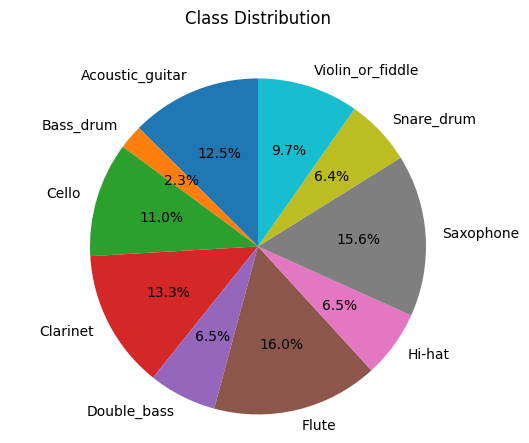

In [8]:
df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

folder_path = r'C:\Users\Ficadot\audio-classification-project\clean'
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
print("number of original samples :",len(files))

for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    # Calculate the duration of the audio file and add it to the dataframe.
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label)) # Extract classes from the dataframe.
class_dist = df.groupby(['label'])['length'].mean() # Compute the average duration of audio files per class.

# Determine the total number of samples to generate,
# based on the sum of audio lengths and a chosen time frame (0.1 seconds here).
n_samples = 2 * int(df['length'].sum()/0.1) 
# Create a probability distribution for class selection, based on class duration.
prob_dist = class_dist / class_dist.sum()
# Randomly choose classes based on the probability distribution.
choices = np.random.choice(class_dist.index, p=prob_dist)
print("number of final samples :",n_samples)
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()


## Feature Building Function

The `build_rand_feat` function is a key component of the audio processing pipeline. It constructs the feature set for the machine learning model by extracting Mel Frequency Cepstral Coefficients (MFCCs) from the audio files.

In [12]:
def build_rand_feat() :
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        # Extract MFCC features from the audio sample.
        X_sample = mfcc(sample ,rate ,numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T

        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    # Normalize the features to be within the range [0, 1].
    X = (X - _min) / (_max - _min)

    # Reshape the feature array based on the model type.
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes=10)
    config.data = (X,y)

    return X, y

## Model Setup and Training

1) Feature Preparation
Before training, we need to prepare our features (the inputs to our model) and our labels (the expected outputs). This is done by the `build_rand_feat()` function.

2) Train/Test Split
To evaluate our model's performance, we need to test it on unseen data. Therefore, we split our dataset into a training set and a testing set. Typically, we allocate 70% of the data for training and 30% for testing, which is accomplished with the `train_test_split` function from `sklearn.model_selection`.

3) Model Definition

4) Model Training
The `train_model` function trains the model using the features and labels of the training set. During training, we use class weights to handle imbalanced datasets, which is a common issue in audio classification tasks. Class weights are calculated using the `compute_class_weights` function, which helps to give more importance to under-represented classes.

5) Callbacks
During training, we use a `ModelCheckpoint` callback to save the best version of the model based on the validation accuracy (`val_acc`). This ensures that we keep the model that performs best on the validation set.

6) Model Saving
After training, we save the model to an HDF5 file (`model.h5`). This file contains the architecture of the model, the model weights, and the training configuration.

In [10]:
def setup_model(config):
    # Build features and labels
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Determine the input shape based on the mode
    if config.mode == 'conv':
        input_shape = (X.shape[1], X.shape[2], 1)
        model = get_conv_model(input_shape)
    elif config.mode == 'time':
        input_shape = (X.shape[1], X.shape[2])
        model = get_recurrent_model(input_shape)
    else:
        raise ValueError("Mode should be either 'conv' or 'time'")

    return X_train, X_test, y_train, y_test, model

def train_model(X_train, y_train, model, config):
    y_flat = np.argmax(y_train, axis=1)
    class_weights = compute_class_weights(y_flat)

    checkpoint = ModelCheckpoint(
        'model_'+ config.mode +'.h5', monitor='val_acc', verbose=0,
        mode='max', save_best_only=True, save_weights_only=False, save_freq='epoch'
    )
    
    history = model.fit(
        X_train, y_train, epochs=50, batch_size=16, shuffle=True,
        validation_split=0.2, class_weight=class_weights, callbacks=[checkpoint]
    )
    
    model.save('model_'+ config.mode +'.h5')

    return history
    
from collections import Counter
def compute_class_weights(y_flat):
    class_counts = Counter(y_flat)
    total_samples = len(y_flat)
    return {class_label: total_samples / class_count for class_label, class_count in class_counts.items()}


### Conv Training

In [13]:
config = Config(mode='conv')  
X_train, X_test, y_train, y_test, model = setup_model(config)

  0%|          | 0/26404 [00:00<?, ?it/s]

100%|██████████| 26404/26404 [01:05<00:00, 403.96it/s]


In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)    
print(y_test.shape)
model.summary()

(18482, 13, 9, 1)
(7922, 13, 9, 1)
(18482, 10)
(7922, 10)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 9, 16)         160       
                                                                 
 batch_normalization (BatchN  (None, 13, 9, 16)        64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 9, 16)         2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 4, 16)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 4, 32)          4640      
                                                                

In [15]:
history = train_model(X_train, y_train, model, config)

Epoch 1/50
925/925 [==============================] - 21s 18ms/step - loss: 9.3311 - accuracy: 0.6580 - val_loss: 0.8295 - val_accuracy: 0.7390
Epoch 2/50
925/925 [==============================] - 16s 17ms/step - loss: 5.7450 - accuracy: 0.7903 - val_loss: 0.6521 - val_accuracy: 0.7947
Epoch 3/50
925/925 [==============================] - 16s 17ms/step - loss: 4.5521 - accuracy: 0.8346 - val_loss: 0.5640 - val_accuracy: 0.8274
Epoch 4/50
925/925 [==============================] - 16s 17ms/step - loss: 3.6995 - accuracy: 0.8674 - val_loss: 0.6260 - val_accuracy: 0.8144
Epoch 5/50
925/925 [==============================] - 16s 17ms/step - loss: 3.9262 - accuracy: 0.8563 - val_loss: 0.4635 - val_accuracy: 0.8661
Epoch 6/50
925/925 [==============================] - 16s 18ms/step - loss: 3.1055 - accuracy: 0.8865 - val_loss: 0.4007 - val_accuracy: 0.8956
Epoch 7/50
925/925 [==============================] - 20s 22ms/step - loss: 2.8301 - accuracy: 0.9000 - val_loss: 0.4596 - val_accuracy:

### Accuracy and Loss Plots

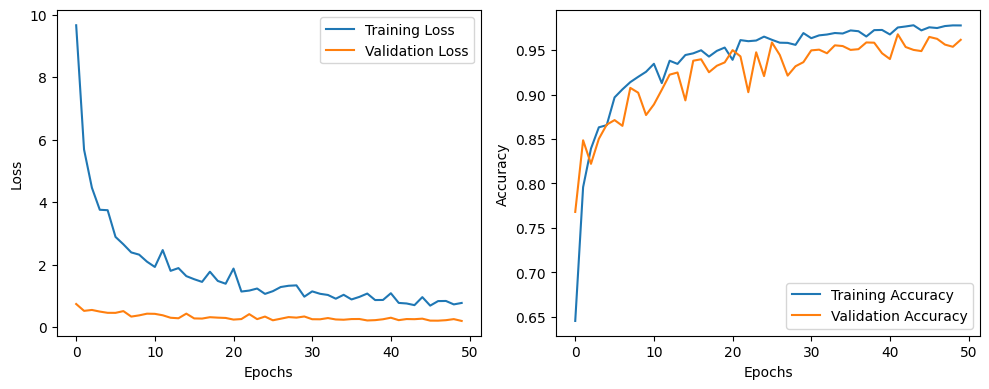

In [62]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [63]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.2056
Test Accuracy: 0.9601


### Confusion Matrix

  1/248 [..............................] - ETA: 5s

248/248 [==============================] - 2s 7ms/step


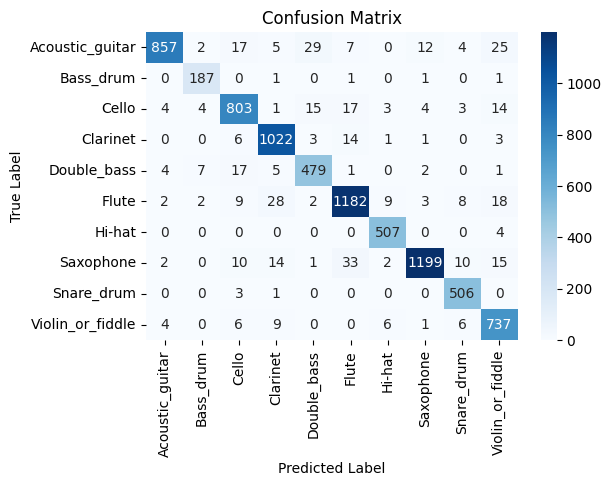

7922

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
len(y_pred_classes)
len(y_true_classes)

### Receiver Operating Characteristic Curve

248/248 [==============================] - 3s 13ms/step


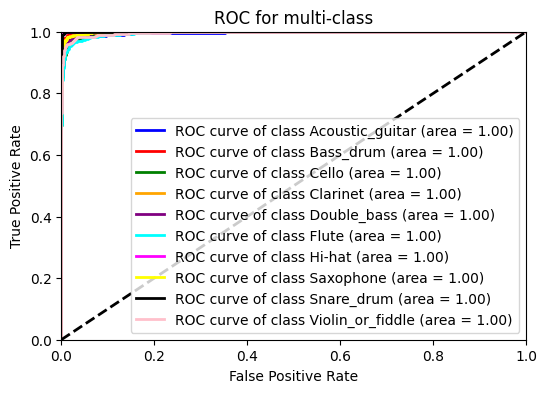

In [81]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

# Binarize the labels for multiclass ROC
y_test_binarized = label_binarize(y_true_classes, classes=np.unique(y_true_classes))
y_scores = model.predict(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 4))

colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class')
plt.legend(loc="lower right")
plt.show()

### LSTM Training

In [66]:
config = Config(mode='time')  
X_train, X_test, y_train, y_test, model = setup_model(config)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

100%|██████████| 26404/26404 [00:41<00:00, 630.13it/s]


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 13, 128)           70656     
                                                                 
 batch_normalization_16 (Bat  (None, 13, 128)          512       
 chNormalization)                                                
                                                                 
 lstm_5 (LSTM)               (None, 13, 128)           131584    
                                                                 
 batch_normalization_17 (Bat  (None, 13, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 13, 128)           0         
                                                                 
 time_distributed_8 (TimeDis  (None, 13, 64)          

In [67]:
history = train_model(X_train, y_train, model, config)

Epoch 1/50
925/925 [==============================] - 29s 27ms/step - loss: 14.8773 - acc: 0.4146 - val_loss: 1.2157 - val_acc: 0.5897
Epoch 2/50
925/925 [==============================] - 17s 19ms/step - loss: 10.1491 - acc: 0.6171 - val_loss: 0.9022 - val_acc: 0.6998
Epoch 3/50
925/925 [==============================] - 14s 15ms/step - loss: 8.0763 - acc: 0.7000 - val_loss: 0.7605 - val_acc: 0.7695
Epoch 4/50
925/925 [==============================] - 13s 14ms/step - loss: 6.9748 - acc: 0.7426 - val_loss: 0.7375 - val_acc: 0.7587
Epoch 5/50
925/925 [==============================] - 13s 14ms/step - loss: 6.1415 - acc: 0.7686 - val_loss: 0.6925 - val_acc: 0.7814
Epoch 6/50
925/925 [==============================] - 13s 14ms/step - loss: 5.4753 - acc: 0.7933 - val_loss: 0.7600 - val_acc: 0.7536
Epoch 7/50
925/925 [==============================] - 13s 14ms/step - loss: 5.1571 - acc: 0.8065 - val_loss: 0.5413 - val_acc: 0.8323
Epoch 8/50
925/925 [==============================] - 13s 14

### Accuracy and Loss Plots

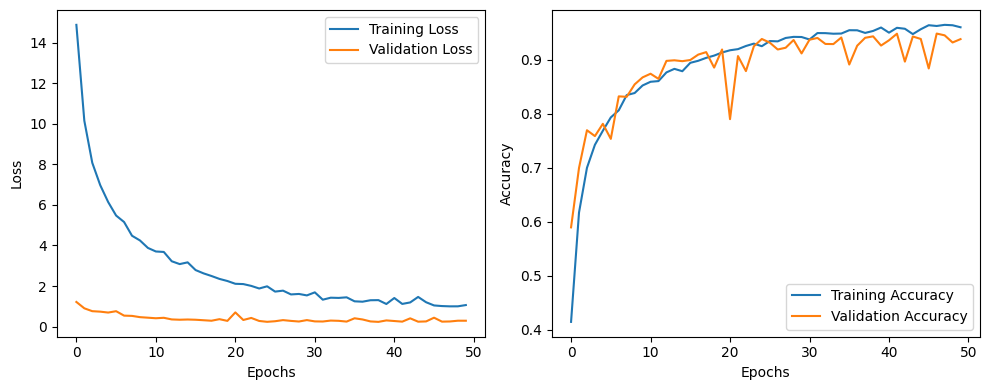

In [68]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.2585
Test Accuracy: 0.9441


248/248 [==============================] - 6s 18ms/step


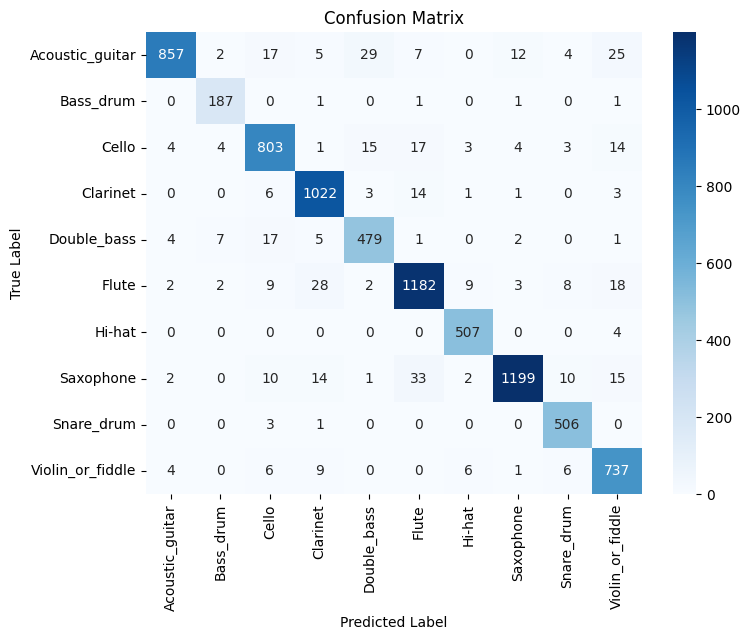

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Receiver Operating Characteristic Curve

248/248 [==============================] - 4s 18ms/step


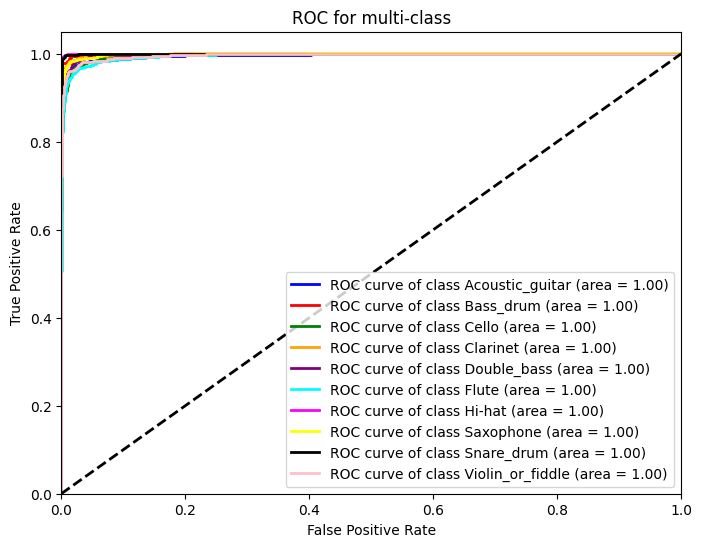

In [71]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

# Binarize the labels for multiclass ROC
y_test_binarized = label_binarize(y_true_classes, classes=np.unique(y_true_classes))
y_scores = model.predict(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))

colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class')
plt.legend(loc="lower right")
plt.show()
